## QB Data Analysis

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
qb_file = "qb_games_more_10.csv"

In [2]:
qb_data = pd.read_csv(qb_file)
qb_data.head()

,Unnamed: 0,name,id,Year,Date,G.,Age,Tm,X,Opp,Result,GS,Cmp,Att,Cmp.,Yds,TD,Int,Rate,Sk,Yds.1,Y.A,AY.A,Att.1,Yds.2,Y.A.1,TD.1,TD.2,Pts,Fmb,FF,FR,Yds.3,TD.3
0,31,A.J. Feeley,FeelA.00,2001,2002-01-06,16,24.235,PHI,@,TAM,W 17-13,NaN,10.0,14.0,71.43,143.0,2.0,1.0,114.0,0.0,0.0,10.21,9.86,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33,A.J. Feeley,FeelA.00,2002,2002-12-01,12,25.199,PHI,NaN,STL,W 10-3,*,14.0,30.0,46.67,181.0,0.0,0.0,66.1,3.0,24.0,6.03,6.03,2.0,3.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34,A.J. Feeley,FeelA.00,2002,2002-12-08,13,25.206,PHI,@,SEA,W 27-20,*,21.0,35.0,60.00,190.0,2.0,1.0,81.8,0.0,0.0,5.43,5.29,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35,A.J. Feeley,FeelA.00,2002,2002-12-15,14,25.213,PHI,NaN,WAS,W 34-21,*,16.0,28.0,57.14,220.0,2.0,1.0,91.4,2.0,10.0,7.86,7.68,2.0,5.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,A.J. Feeley,FeelA.00,2002,2002-12-21,15,25.219,PHI,@,DAL,W 27-3,*,19.0,33.0,57.58,253.0,1.0,2.0,66.9,1.0,8.0,7.67,5.55,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Cleaning

In [3]:
# 26951 games included, with 34 columns
qb_data.shape

(26951, 34)

In [4]:
# see which columns have na values
qb_data.isna().any()[qb_data.isna().any() == True]

X        True
GS       True
Cmp      True
Cmp.     True
Yds      True
TD       True
Int      True
Rate     True
Sk       True
Yds.1    True
Y.A      True
AY.A     True
Att.1    True
Yds.2    True
Y.A.1    True
TD.1     True
TD.2     True
Pts      True
Fmb      True
FF       True
FR       True
Yds.3    True
TD.3     True
dtype: bool

In [5]:
# replace most NA values with 0
columns_to_set_na_to_0 = ['Cmp','Cmp.','Yds','TD','Int','Rate','Sk','Yds.1','Y.A','AY.A','Att.1','Yds.2','Y.A.1','TD.1','TD.2','Pts','Fmb','FF','FR','Yds.3','TD.3']
qb_data[columns_to_set_na_to_0] = qb_data[columns_to_set_na_to_0].fillna(0)
# make game started a boolean
qb_data['GS'] = qb_data['GS'] == "*"
# get rid of this random column
qb_data = qb_data.drop('Unnamed: 0', axis=1)

In [6]:
# extract a win from the result column with a 1, or a 0 for a loss
qb_data['team_win'] = [1 if "W" in x else 0 for x in qb_data['Result']]
# get a list of games the team won that that QB started
qb_data['start_win'] = [1 if ("W" in qb_data.loc[i,'Result'] and qb_data.loc[i,'GS'] == True) else 0 for i in range(qb_data.shape[0])]

In [7]:
games_started = []
last_qb = None
for index, row in qb_data.iterrows():
    current_qb = row.id
    if current_qb != last_qb:
        if row['GS'] == True:
            gs_count = 1
        else:
            gs_count = 0
    else:
        if row['GS'] == True:
            gs_count += 1
    games_started.append(gs_count)
    last_qb = current_qb
qb_data['game_count'] = qb_data.groupby('id').cumcount()
qb_data['start_count'] = games_started

In [8]:
# get the total number of games a player played and started in their career, and
qb_total_games = qb_data.groupby(['id', 'name'])['game_count', 'start_count', 'Year'].max().reset_index('name')
#qb_games_started = qb_data.groupby(['name','id'])['start_count'].max()
qb_total_games.head()

,name,game_count,start_count,Year
id,,,,
AdamTo00,Tony Adams,13,9,1987
AikmTr00,Troy Aikman+,171,171,2000
AlbeFr00,Frankie Albert,29,28,1952
AlleJo02,Josh Allen,5,5,2018
AndeDe00,Derek Anderson,54,48,2018


In [9]:
# get sum totals for each QB on the following columns
sum_columns =['Cmp', 'Att','Yds','TD','Int','Sk','Fmb','team_win','start_win']
qb_totals = qb_data.groupby(['name', 'id'])[sum_columns].sum()#.reset_index('name')

# join that table with the games started and total games tables
qb_totals = qb_totals.join(qb_total_games, on='id').drop('name', axis=1).reset_index('name')
#qb_totals.join(qb_totals.groupby('id')['Year'].max())

In [10]:
# add some more columns based on career totals
qb_totals['Cmp.'] = qb_totals['Cmp'] / qb_totals['Att']
qb_totals['Y.A'] = qb_totals['Yds'] / qb_totals['Att']
qb_totals['TD_pct'] = qb_totals['TD'] / qb_totals['Att']
qb_totals['Int_pct'] = qb_totals['Int'] / qb_totals['Att']
# below is the winning percentage for the team in the games that they started
qb_totals['gs_wp'] = (qb_totals['start_win'] / qb_totals['start_count']).fillna(0)
qb_totals['sack_pg'] = (qb_totals['Sk'] / qb_totals['start_count']).fillna(0)

In [11]:
# just looking at qbs with at least 10 starts
qb_10_starts = qb_totals[qb_totals.start_count >= 10]
qb_10_starts = qb_10_starts.drop(qb_10_starts[qb_10_starts.Cmp < 10].index)
qb_10_starts.shape
# 346 QBs in our dataset with at least 10 starts

(346, 19)

### Exploratory Data Analysis

In [12]:
qb_10_starts.describe()

,Cmp,Att,Yds,TD,Int,Sk,Fmb,team_win,start_win,game_count,start_count,Year,Cmp.,Y.A,TD_pct,Int_pct,gs_wp,sack_pg
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,1230.364162,2144.642457,14959.684971,92.846821,80.471098,108.682081,7.445087,36.135838,34.745665,73.112717,68.560694,1994.378613,0.554452,6.708805,0.039507,0.041655,0.440455,1.738933
std,1208.892964,1981.848743,14535.738498,98.184253,68.174716,125.893641,16.840381,37.248348,36.970008,61.447576,61.071145,18.302879,0.071458,0.651355,0.010678,0.015084,0.150776,1.270138
min,92.000000,239.000000,1199.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,9.000000,10.000000,1951.000000,0.382838,4.328520,0.011338,0.013672,0.000000,0.000000
25%,340.000000,644.000000,4021.500000,23.250000,27.000000,2.250000,0.000000,9.000000,8.000000,24.250000,20.000000,1979.250000,0.518705,6.359342,0.032562,0.030565,0.358974,0.043128
50%,769.000000,1398.000000,9106.500000,53.000000,58.000000,63.000000,0.000000,21.000000,19.000000,50.500000,45.000000,1997.500000,0.555775,6.778566,0.039503,0.038334,0.461538,2.019808
75%,1830.000000,3191.500000,22582.250000,138.000000,110.750000,171.250000,7.000000,55.750000,53.000000,111.500000,102.750000,2010.750000,0.591620,7.101500,0.045196,0.051906,0.538462,2.660000
max,6781.000000,10938.000000,79104.000000,578.000000,361.000000,556.000000,102.000000,230.000000,230.000000,320.000000,319.000000,2018.000000,1.353786,9.048295,0.082386,0.118667,0.900000,5.000000


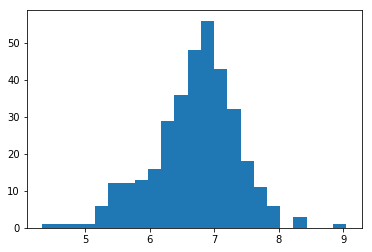

In [13]:
# Let's look at some stats to see how they are distributed
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(qb_10_starts['Y.A'], bins="auto")
plt.show()

### Y/A looks pretty normally distributed as a predictor variable

In [14]:
qb_10_starts['Y.A'].describe()

count    346.000000
mean       6.708805
std        0.651355
min        4.328520
25%        6.359342
50%        6.778566
75%        7.101500
max        9.048295
Name: Y.A, dtype: float64

### Below I separate the QBs with 10 starts into two groups: one called 'retired QBs', which are those that haven't played in 2018, and those who are still playing

In [15]:
retired_qbs = qb_10_starts[qb_10_starts.Year < 2018]
current_qbs = qb_10_starts[qb_10_starts.Year == 2018]

### Next, I choose some variables that I am going to use to group players into clusters. These are some stats that are often used to judge performance:
* start_count: how many starts did the player make in their career? If you were able to play a long time, it's likely that you provided value to your team for that span of time.
* Y.A: this is yards per attempt, a common measure of QB efficiency. The more yards you are able to get per play, the more efficient you likely are at having long drives and scoring.
* TD_pct: what percentage of your attempts turned into touchdowns? Touchdowns are how points are scored, and a QB's ability to score touchdowns is a crucial measure of success.
* Int_pct: what percentage of your attempts turned into interceptions? Interceptions are very bad for a quarterback, as it gives the othr team the ball and removes one of the few posessions per game that a team gets. This is a negative but important statistic.
* gs_wp: what percent of games that you started did your team win? Arguably the most important stat for a QB. Football is a team game, however the QB is the most influential player on a team towards winning a game. Ultimately, this is how a QB is judged by fans and teams alike.

In [16]:
from sklearn.preprocessing import scale
retired_cluster_stats = retired_qbs[['start_count', 'Y.A', 'TD_pct','Int_pct','gs_wp']]
# scale the stats for clustering so they are each on a level playing field
scaled_cluster_stats = pd.DataFrame(scale(retired_cluster_stats), index=retired_cluster_stats.index, columns=retired_cluster_stats.columns)

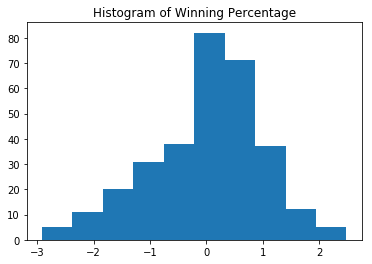

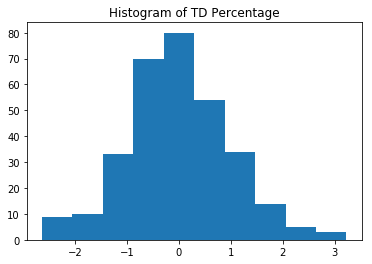

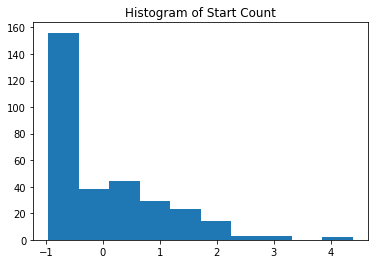

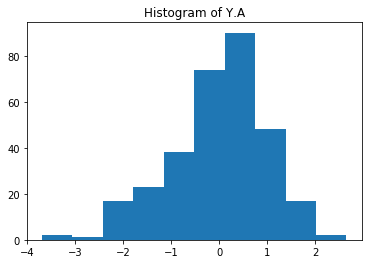

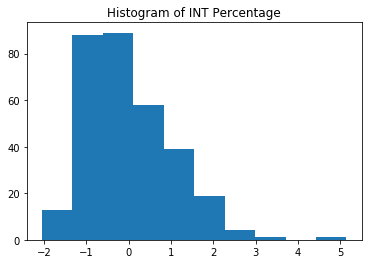

In [17]:
# Histogram of scaled winning percentage stats, not perfectly normal but not awful
plt.hist(scaled_cluster_stats['gs_wp'])
plt.title("Histogram of Winning Percentage")
plt.show()
plt.hist(scaled_cluster_stats['TD_pct'])
plt.title("Histogram of TD Percentage")
plt.show()
plt.title("Histogram of Start Count")
plt.hist(scaled_cluster_stats['start_count'])
plt.show()
plt.title("Histogram of Y.A")
plt.hist(scaled_cluster_stats['Y.A'])
plt.show()
plt.title("Histogram of INT Percentage")
plt.hist(scaled_cluster_stats['Int_pct'])
plt.show()

In [18]:
from sklearn.cluster import KMeans
clusters = 3
kmeans = KMeans(n_clusters = clusters, random_state = 1).fit(scaled_cluster_stats)

In [19]:
scaled_cluster_stats['tier'] = kmeans.labels_ 
retired_qbs['tier'] = kmeans.labels_

/Users/Beni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
for i in range(0,clusters):
    print(i)
    print(retired_cluster_stats[scaled_cluster_stats['tier'] == i].describe())
    

#tier 0 is elite
#tier 1 is bad
#tier 2 is average

0
       start_count         Y.A      TD_pct     Int_pct       gs_wp
count   106.000000  106.000000  106.000000  106.000000  106.000000
mean    122.254717    7.188980    0.048418    0.044873    0.534546
std      59.010259    0.357329    0.007848    0.013885    0.092668
min      10.000000    6.404372    0.033822    0.022563    0.321429
25%      91.250000    6.928760    0.043171    0.033331    0.472560
50%     125.500000    7.156319    0.046979    0.043200    0.526794
75%     157.750000    7.422383    0.053207    0.053861    0.604871
max     319.000000    8.318486    0.072438    0.080685    0.797297
1
       start_count        Y.A     TD_pct    Int_pct      gs_wp
count    78.000000  78.000000  78.000000  78.000000  78.000000
mean     20.910256   5.941815   0.029789   0.053002   0.268118
std      12.698487   0.574127   0.008673   0.016675   0.131861
min      10.000000   4.328520   0.011338   0.025478   0.000000
25%      12.000000   5.521918   0.023665   0.040095   0.175889
50%      15.500

In [21]:
qb_data_with_tiers = qb_data
qb_data_with_tiers = qb_data_with_tiers.set_index(['id']).join(retired_qbs['tier'])


In [22]:
retired_qb_with_tiers = qb_data_with_tiers[np.isnan(qb_data_with_tiers['tier']) == False]
len(set(retired_qb_with_tiers.index.values))

309

### Random Forest Classifier

In [23]:
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [24]:
#take the
retired_qb_with_tiers.head()

,name,Year,Date,G.,Age,Tm,X,Opp,Result,GS,Cmp,Att,Cmp.,Yds,TD,Int,Rate,Sk,Yds.1,Y.A,AY.A,Att.1,Yds.2,Y.A.1,TD.1,TD.2,Pts,Fmb,FF,FR,Yds.3,TD.3,team_win,start_win,game_count,start_count,tier
AikmTr00,Troy Aikman+,1989,1989-09-10,1,22.293,DAL,@,NOR,L 0-28,True,17.0,35.0,48.57,180.0,0.0,2.0,40.2,2.0,30.0,5.14,2.57,1.0,13.0,13.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
AikmTr00,Troy Aikman+,1989,1989-09-17,2,22.300,DAL,@,ATL,L 21-27,True,13.0,23.0,56.52,241.0,1.0,2.0,71.1,0.0,0.0,10.48,7.43,5.0,13.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,2,0.0
AikmTr00,Troy Aikman+,1989,1989-09-24,3,22.307,DAL,NaN,WAS,L 7-30,True,6.0,21.0,28.57,83.0,0.0,2.0,4.0,4.0,27.0,3.95,-0.33,1.0,3.0,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,3,0.0
AikmTr00,Troy Aikman+,1989,1989-11-12,10,22.356,DAL,@,PHO,L 20-24,True,21.0,40.0,52.50,379.0,2.0,2.0,81.1,1.0,12.0,9.48,8.23,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,4,0.0
AikmTr00,Troy Aikman+,1989,1989-11-19,11,22.363,DAL,NaN,MIA,L 14-17,True,25.0,33.0,75.76,261.0,1.0,1.0,95.6,0.0,0.0,7.91,7.15,8.0,71.0,8.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4,5,0.0


In [25]:
retired_qb_with_tiers.index.name='id'

In [27]:
def get_stats_for_first_x_games(full_data, games, player_name = None):
    reduced_data = full_data[full_data['start_count'] <= int(games)]
    if player_name is not None:
        reduced_data = reduced_data[reduced_data.name == player_name]
    #return(reduced_data)
    sum_columns =['Cmp', 'Att','Yds','TD','Int', 'team_win','start_win']
    qb_totals = reduced_data.groupby('id')[sum_columns].sum()
    qb_totals['total_game_starts'] = full_data.groupby('id')['start_count'].max()
    
    
    qb_totals['total_games'] = [x if x < games else games for x in qb_totals['total_game_starts']]
    qb_totals['Cmp.'] = qb_totals['Cmp'] / qb_totals['Att']
    qb_totals['Y.A'] = qb_totals['Yds'] / qb_totals['Att']
    qb_totals['TD_pct'] = qb_totals['TD'] / qb_totals['Att']
    qb_totals['Int_pct'] = qb_totals['Int'] / qb_totals['Att']
    qb_totals['gs_wp'] = (qb_totals['start_win'] / qb_totals['total_games']).fillna(0)
    #if 'tier' in qb_totals:
    qb_totals['tier'] = reduced_data.groupby('id')['tier'].max()
    return(qb_totals)

### cross validation

In [28]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle=True, random_state=10)
averages = list()
bad_averages = list()
reg_averages = list()
for i in np.arange(1,80):
    first_x_games = get_stats_for_first_x_games(retired_qb_with_tiers, i)
    first_x_games['tier_fact'] = first_x_games['tier'].astype('category')
    X = first_x_games[['Y.A', 'TD_pct', 'Int_pct','gs_wp']]
    y = first_x_games['tier_fact']
    errors = list()
    bad_errors = list()
    reg_errors = list()
    for train, test in kf.split(X):
        X_train =  X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        reversefactor = dict(zip(range(5),["0","1","2","3","4"]))
        y_test = np.vectorize(reversefactor.get)(y_test)
        y_pred = np.vectorize(reversefactor.get)(y_pred)
        errors.append(sum(y_test != y_pred)/len(y_test))
        bad_errors.append((sum(y_pred[y_test == '1'] == '0') + sum(y_pred[y_test == '0'] == '1'))/len(y_test))
    averages.append(np.mean(errors))   
    bad_averages.append(np.mean(bad_errors))

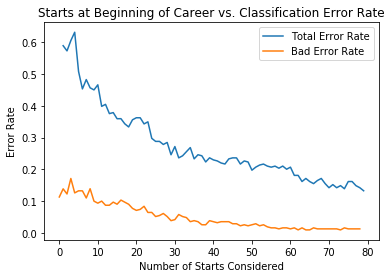

In [29]:
plt.plot(np.arange(1,80), averages, bad_averages)
plt.title('Starts at Beginning of Career vs. Classification Error Rate')
plt.xlabel('Number of Starts Considered')
plt.ylabel('Error Rate')
plt.legend(['Total Error Rate', 'Bad Error Rate'])
plt.show()

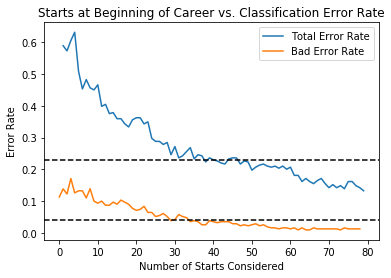

In [30]:
plt.plot(np.arange(1,80), averages, bad_averages)
plt.title('Starts at Beginning of Career vs. Classification Error Rate')
plt.xlabel('Number of Starts Considered')
plt.ylabel('Error Rate')
plt.legend(['Total Error Rate', 'Bad Error Rate'])
plt.axhline(y=.23, color='black', linestyle = '--')
plt.axhline(y=.04, color='black', linestyle = '--')
plt.show()

## Predicting Which Tier Current QBs will End Up in
#### As discussed above, we need at least 30 games to have a good sense of how good the QB will be, so I will only be predicting for QBs that have at least 30 starts to date.

In [42]:
qualified_qbs = current_qbs[current_qbs.start_count >= 30]
qualified_qbs['name']

RodgAa00         Aaron Rodgers
SmitAl03            Alex Smith
LuckAn00           Andrew Luck
DaltAn00           Andy Dalton
RoetBe00    Ben Roethlisberger
GabbBl00        Blaine Gabbert
BortBl00         Blake Bortles
OsweBr00        Brock Osweiler
NewtCa00            Cam Newton
WentCa00          Carson Wentz
KeenCa00           Case Keenum
Dak1              Dak Prescott
AndeDe00        Derek Anderson
DC02                Derek Carr
BreeDr00            Drew Brees
MannEl00           Eli Manning
GoffJa00            Jared Goff
FlacJo00            Joe Flacco
CousKi00          Kirk Cousins
MM02            Marcus Mariota
RyanMa00             Matt Ryan
StafMa00      Matthew Stafford
FoleNi00            Nick Foles
RivePh00         Philip Rivers
FitzRy00      Ryan Fitzpatrick
TannRy00        Ryan Tannehill
BradSa00          Sam Bradford
BradTo00             Tom Brady
TaylTy00          Tyrod Taylor
Name: name, dtype: object

In [39]:
predictions = list()
for index, row in current_qbs.iterrows():
    #if index == 'RodgAa00':
    player_starts = row['start_count']
    retired_first_x_games = get_stats_for_first_x_games(retired_qb_with_tiers, player_starts)
    retired_first_x_games['tier_fact'] = retired_first_x_games['tier'].astype('category')
    X = retired_first_x_games[['Y.A', 'TD_pct', 'Int_pct','gs_wp']]
    y = retired_first_x_games['tier_fact']
    classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 2)
    classifier.fit(X, y)
    player_stats = row[['Y.A', 'TD_pct', 'Int_pct','gs_wp']]
    player_prediction = classifier.predict([player_stats])
    predictions.append(player_prediction.astype('int')[0])
current_qbs['predicted_tier'] = predictions

/Users/Beni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
def replace_tier_number_with_description(tier):
    if tier == 2:
        return('Average')
    if tier == 0:
        return('Great')
    if tier == 1:
        return('Scrub')

In [41]:
current_qbs['predicted_tier'] = current_qbs.predicted_tier.apply(replace_tier_number_with_description)
current_qbs[['name', 'predicted_tier']]

/Users/Beni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,name,predicted_tier
RodgAa00,Aaron Rodgers,Great
SmitAl03,Alex Smith,Average
LuckAn00,Andrew Luck,Great
DaltAn00,Andy Dalton,Great
RoetBe00,Ben Roethlisberger,Great
GabbBl00,Blaine Gabbert,Scrub
BortBl00,Blake Bortles,Average
OsweBr00,Brock Osweiler,Average
BeatC.00,C.J. Beathard,Great
NewtCa00,Cam Newton,Great
